<a href="https://colab.research.google.com/github/oreomcflurryyy/data-analysis/blob/main/cats_dogs_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

### Load the data: the Cats vs Dogs dataset

In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   205M      0  0:00:03  0:00:03 --:--:--  205M


In [7]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [9]:
!ls PetImages

Cat  Dog


Filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [10]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Generate a Dataset

In [11]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Count labels in training and validation datasets. This will show whether our dataset has training data balance or not. Spoilers, it does!

In [30]:
def count_labels(dataset):
    cat_count = 0
    dog_count = 0
    for _, labels in dataset:
        labels_np = labels.numpy()
        cat_count += np.sum(labels_np == 0)
        dog_count += np.sum(labels_np == 1)
    return cat_count, dog_count

In [31]:
train_cat_count, train_dog_count = count_labels(train_ds)
val_cat_count, val_dog_count = count_labels(val_ds)

print(f"Number of cats in training set: {train_cat_count}")
print(f"Number of dogs in training set: {train_dog_count}")
print(f"Number of cats in validation set: {val_cat_count}")
print(f"Number of dogs in validation set: {val_dog_count}")

Number of cats in training set: 9384
Number of dogs in training set: 9344
Number of cats in validation set: 2357
Number of dogs in validation set: 2325


### Visualize the data
Here are the first 9 images in the training dataset.

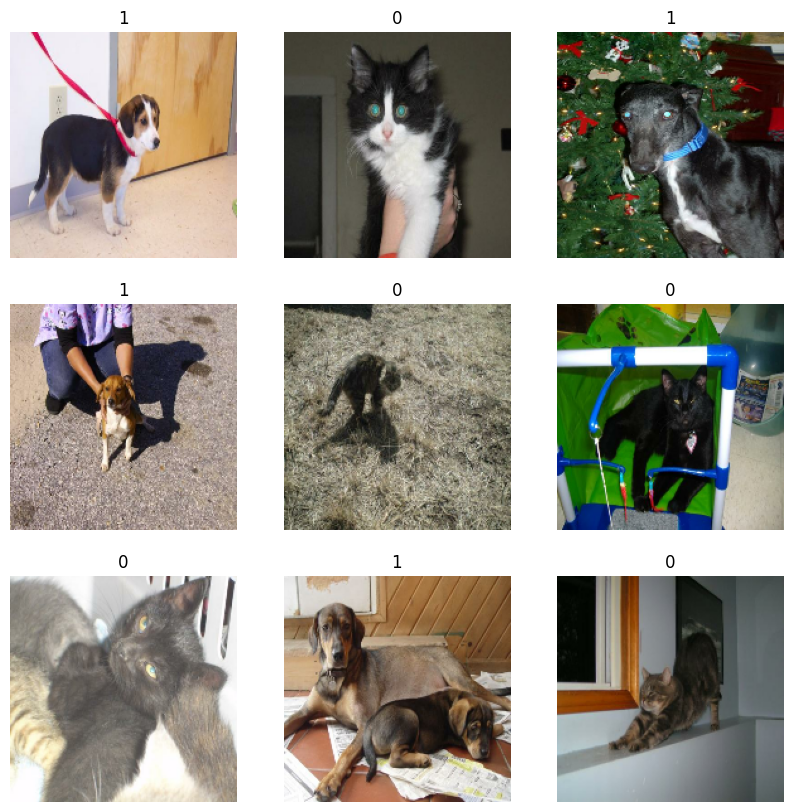

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Using image data augmentation
By applying data augmentation, you can help your model generalize better by exposing it to a wider variety of input data during training.

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [14]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

Prefetching allows the data loading to happen in the background while the model is training, which can improve performance.

In [15]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset

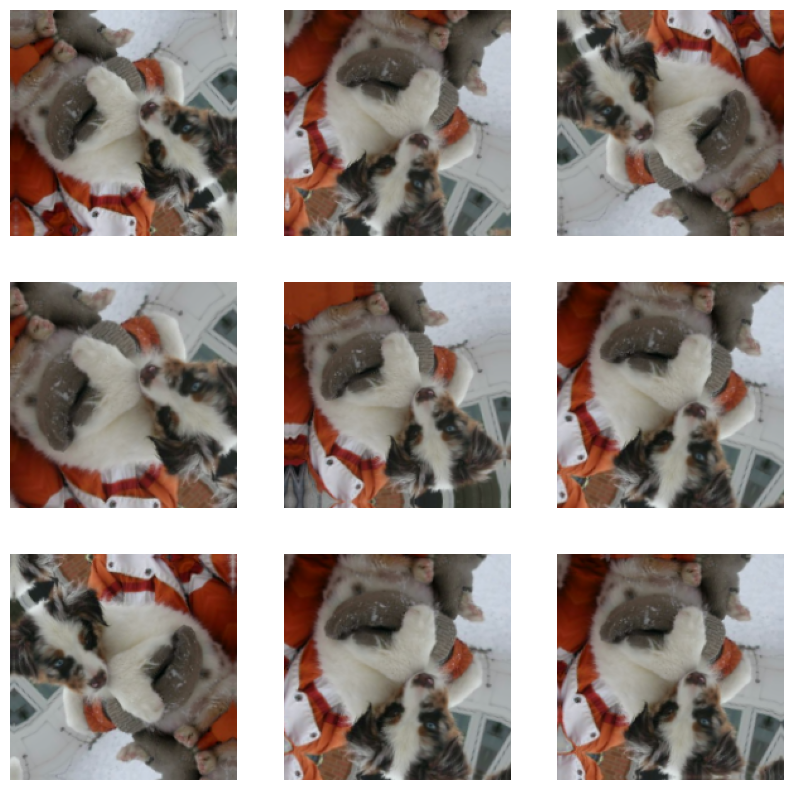

In [16]:
for images, _ in train_ds.take(1):

    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

    plt.show()

### Build a model

Images are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. We will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [17]:
model = keras.Sequential([
    layers.InputLayer(shape=(180, 180, 3)),
    data_augmentation,  # Include the augmentation layer in the model
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation=None)  # Assuming binary classification
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,166,657 (57.86 MB)

 Trainable params: 15,166,657 (57.86 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - acc: 0.5479 - loss: 0.7879 - val_acc: 0.6617 - val_loss: 0.6082
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - acc: 0.6497 - loss: 0.6027 - val_acc: 0.6907 - val_loss: 0.6103
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - acc: 0.6657 - loss: 0.5835 - val_acc: 0.6991 - val_loss: 0.6213
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - acc: 0.6784 - loss: 0.5766 - val_acc: 0.6762 - val_loss: 0.6861
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - acc: 0.6811 - loss: 0.5688 - val_acc: 0.7112 - val_loss: 0.5457
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - acc: 0.6957 - loss: 0.5545 - val_acc: 0.7253 - val_loss: 0.5591
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.6974 - loss: 0.5444 - val_acc: 0.7153 - val_loss: 0.5332
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - acc: 0.7104 - loss: 0.5369 - val_acc: 0.7091 - val_loss: 0.5393
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/

### Run inference on new data

Load the last saved trained model.

In [19]:
model = keras.models.load_model('save_at_10.keras')

Preprocess and load a new image to get predictions.

In [24]:
def load_and_preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

image_path = 'cat-sample.jpg'
image = load_and_preprocess_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image is 97.87% cat and 2.13% dog.


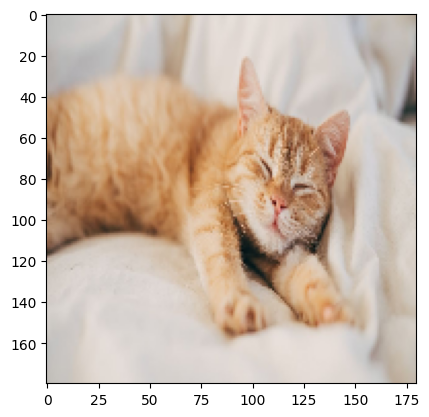

In [27]:
predictions = model.predict(image)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

plt.imshow(image[0])
plt.show()